# 🏗️Import Necessary Libraries

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The code imports various data science libraries, including TensorFlow and scikit-learn, and defines a neural network model using the EfficientNet architecture. It also includes system libraries for handling file paths and metrics for evaluating model performance. Additionally, it sets up various callbacks and optimizers to optimize the training process.</p>

In [1]:
#!pip install tensorflow
#!pip install opencv-python
#!pip install cv2
# !pip install BIRDS
# pip install --upgrade --user pip
# !pip install google.colab

In [2]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
# import birds_utils.BIRDS
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path
import random

# Visualization Libraries
import matplotlib.cm as cm
import cv2
import seaborn as sns
import birds_utils as bu
sns.set_style('darkgrid')

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# 🤙Create helper functions

In [3]:
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# # Import series of helper functions for our notebook
# from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [4]:
# import urllib.request

# url = "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"
# filename = "helper_functions.py"
# urllib.request.urlretrieve(url, filename)

In [5]:
import birds_utils as bu
birds = bu.BIRDS()

# 📥Load and Transform Data

In [6]:
import birds_utils as bu
birds = bu.BIRDS()
project_dir = '.'
birds.load_data(project_dir)
image_df = birds.image_df

In [7]:
birds.image_df

,Filepath,Label
0,data\test\ABBOTTS BABBLER\1.jpg,ABBOTTS BABBLER
1,data\test\ABBOTTS BABBLER\2.jpg,ABBOTTS BABBLER
2,data\test\ABBOTTS BABBLER\3.jpg,ABBOTTS BABBLER
3,data\test\ABBOTTS BABBLER\4.jpg,ABBOTTS BABBLER
4,data\test\ABBOTTS BABBLER\5.jpg,ABBOTTS BABBLER
...,...,...
179765,data\valid\ZEBRA DOVE\1.jpg,ZEBRA DOVE
179766,data\valid\ZEBRA DOVE\2.jpg,ZEBRA DOVE
179767,data\valid\ZEBRA DOVE\3.jpg,ZEBRA DOVE
179768,data\valid\ZEBRA DOVE\4.jpg,ZEBRA DOVE


In [8]:
birds.image_df
# plot all images of a label
# birds.plot_label_images(label=birds.get_labels()[1])

# plot the 1'st 5 instances of a label
# birds.plot_label_images(label=birds.get_labels()[1],N=5)

# # plot images according to idx
# birds.plot_label_images(idx=[1,9])


,Filepath,Label
0,data\test\ABBOTTS BABBLER\1.jpg,ABBOTTS BABBLER
1,data\test\ABBOTTS BABBLER\2.jpg,ABBOTTS BABBLER
2,data\test\ABBOTTS BABBLER\3.jpg,ABBOTTS BABBLER
3,data\test\ABBOTTS BABBLER\4.jpg,ABBOTTS BABBLER
4,data\test\ABBOTTS BABBLER\5.jpg,ABBOTTS BABBLER
...,...,...
179765,data\valid\ZEBRA DOVE\1.jpg,ZEBRA DOVE
179766,data\valid\ZEBRA DOVE\2.jpg,ZEBRA DOVE
179767,data\valid\ZEBRA DOVE\3.jpg,ZEBRA DOVE
179768,data\valid\ZEBRA DOVE\4.jpg,ZEBRA DOVE


In [9]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [10]:
N_labels = 2
label_types = list(image_df['Label'].unique())
label_types[0:2]
image_df = image_df[image_df['Label'].isin(label_types[0:2])]
image_df.Label.unique()

array(['ABBOTTS BABBLER', 'ABBOTTS BOOBY'], dtype=object)

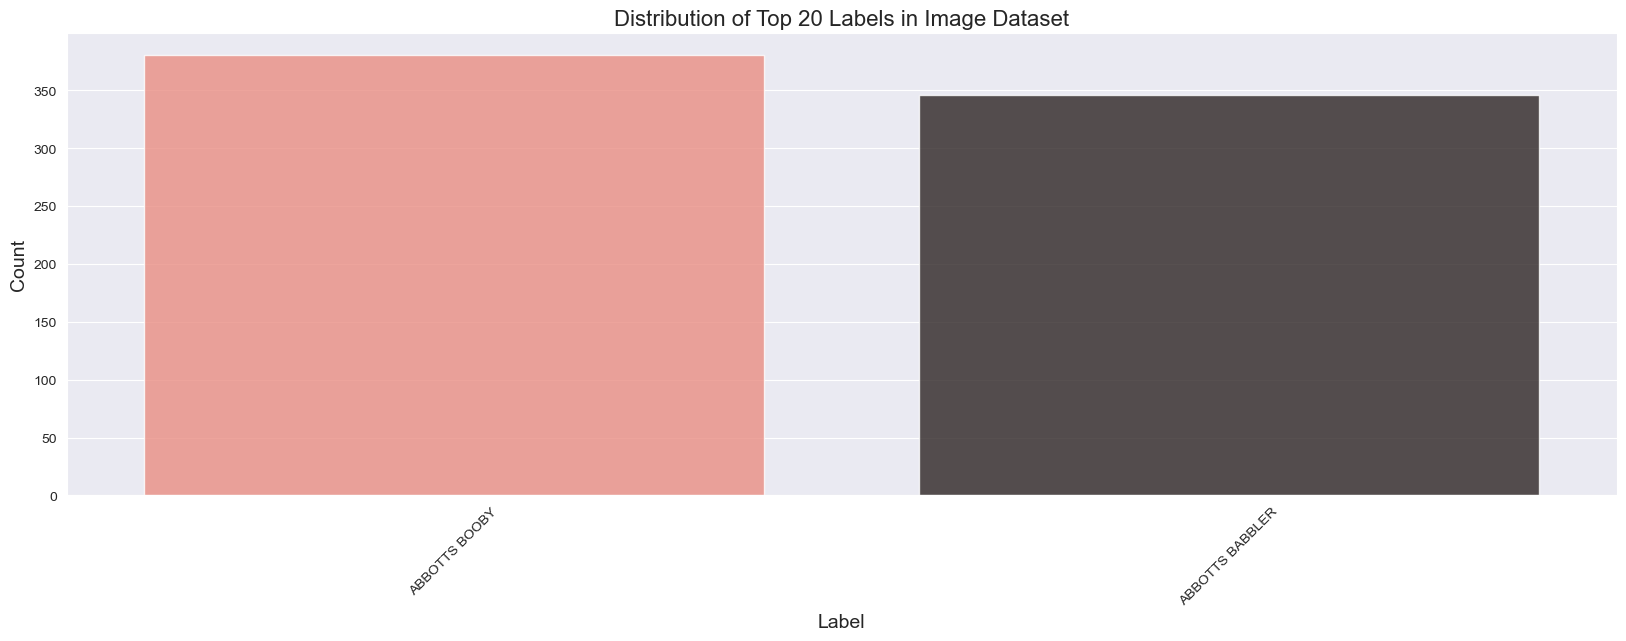

In [11]:
# Get the top 20 labels
label_counts = image_df['Label'].value_counts()[:20]

plt.figure(figsize=(20, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')
plt.title('Distribution of Top 20 Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()

# 🔭Visualizing images from the dataset

# 🧮Computing Error Rate Analysis

<div style="background-color:#fff1cc; padding: 20px;">
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The code below is used for error level analysis (ELA) of images in the context of a animals image classification task.</p>

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The compute_ela_cv() function takes an image path and a quality parameter, compresses the image using JPEG compression at the given quality, and computes the absolute difference between the compressed and original images. The difference is multiplied by a scale factor and returned as an ELA image.</p>

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The convert_to_ela_image() function takes an image path and a quality parameter, compresses the image using JPEG compression at the given quality, computes the absolute difference between the compressed and original images, and returns an ELA image. The ELA image is computed using the difference in pixel values between the original and compressed images, and is normalized to enhance the differences.</p>

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The random_sample() function takes a directory path and an optional file extension, and returns a random file path from that directory with the specified extension (if provided).</p>

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">Finally, the code generates a set of ELA images using the compute_ela_cv() function for a randomly selected image from the test dataset of animals images. The ELA images are generated with decreasing quality levels, resulting in increasing levels of compression and thus increasing levels of error. The resulting images are plotted using matplotlib.</p>

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">Overall, this code provides a way to visually analyze the effect of different levels of JPEG compression on animals images, and may be used to identify optimal quality levels for image compression in the context of a animals image classification task.</p>
</div>

In [12]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')

    items = list(items)

    p = random.choice(items)
    return p.as_posix()

In [13]:
# # View random sample from the dataset
# p = random_sample(dataset+'/train/GOLDEN EAGLE')
# orig = cv2.imread(p)
# orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
# init_val = 100
# columns = 3
# rows = 3

# fig=plt.figure(figsize=(15, 10))
# for i in range(1, columns*rows +1):
#     quality=init_val - (i-1) * 8
#     img = compute_ela_cv(path=p, quality=quality)
#     if i == 1:
#         img = orig.copy()
#     ax = fig.add_subplot(rows, columns, i)
#     ax.title.set_text(f'q: {quality}')
#     plt.imshow(img)
# plt.show()

NameError: name 'dataset' is not defined

<h1 style="font-family:verdana;"> <center>🦜Bird Classification using Deep Convolutional Neural Networks and Transfer Learning</center> </h1>
<p><center style="color:#159364; font-family:cursive; font-size:20px;">Thanks for visiting my notebook </center></p>

***

<center><img src='https://media2.giphy.com/media/SvuYYhf9IuL1fEXq4q/200w.webp?cid=ecf05e47xxpr49vt9ioo8yv14ilsi660fz5fimac7c7thctk&rid=200w.webp&ct=s' height=150px width=200px></center>

# 👋Thanks for Visting my Notebook
<div class="alert alert-block alert-info" style="font-size:20px; font-family:verdana;">
    📌 Feel free to fork or edit the notebook for your own convenience. If you liked the notebook, consider upvoting. It helps other people discover the notebook as well. Your support inspires me to produce more of these kernel.😊
</div>

# 🔬Overview
<div style="background-color:#fff1cc; padding: 20px;">
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">Wildlife conservation has been recently transformed by the application of artificial intelligence. AI helps researchers determine the location of animals, date of sighting, migration patterns, and even an animal social group. AI is used by conservationists to monitor and protect animals in their natural habitat.</p>

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">There are an estimated 30,000 threatened species across the globe. Scientists are utilizing AI to understand what put these species at risk by offering information about where they are born, how many survive, where they go, and how far they go. Following are some advantages of AI in the conservation of animal species:</p>

<ul style="font-size:20px; font-family:verdana; line-height: 1.7em">
    <li>AI facilitates the collection of vast and fascinating datasets and their analysis in no time.</li>
    <li>AI is helping wildlife researchers in studying the wild animal species collectively and making strategies to protect them.</li>
    <li>Artificial intelligence tracks wildlife patterns and predicts the extinction of endangered animal species.</li>
    <li>It helps conservationists to detect and stop wildlife poaching.</li>
    <li>It can provide information about the effects of climate change on wildlife and reducing its impact by designing a proper plan.</li>
    <li>AI assists in assessing the species population and see changes.</li>
    <li>It helps to stop illegal animal trade on social media.</li>
    <li>Artificial intelligence identifies and classifies animal species into various classes and provides detailed information about them.</li>
    <li>AI algorithms can conserve animal habitats by predicting animal migratory patterns.</li>
</ul>
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">Source: <a href="https://aiworldschool.com/research/this-is-why-ai-in-wildlife-conservation-is-so-glorious/">https://aiworldschool.com/research/this-is-why-ai-in-wildlife-conservation-is-so-glorious/</a></p>
</div>


# ❗Author's Note:
<div style="background-color:#d4f1f4; padding: 20px;">
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">Make sure to run the cells from top to bottom with a GPU accelerator. There are some linux commands present in some cells so this is important to take into account. Also, any suggestions, comments and recommendations to improve the notebook will be highly appreciated. Cheers!</p>
</div>


# 📝Data Preprocessing
<div style="background-color:#fff1cc; padding: 20px;">
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The data will be split into three different categories: Training, Validation and Testing. The training data will be used to train the deep learning CNN model and its parameters will be fine tuned with the validation data. Finally, the performance of the data will be evaluated using the test data(data the model has not previously seen).</p>
</div>

In [ ]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

In [ ]:
BATCH_SIZE

In [ ]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [ ]:
57527/4


In [ ]:
test_df

In [ ]:
test_images.filenames

In [ ]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

# 🤹Training the model
<div style="background-color:#fff1cc; padding: 20px;">
  <p style="font-size:20px; font-family:verdana; line-height: 1.7em">The model images will be subjected to a pre-trained CNN model called EfficientNetB0. Three callbacks will be utilized to monitor the training. These are: Model Checkpoint, Early Stopping, Tensorboard callback. The summary of the model hyperparameter is shown as follows:</p>

  <p style="font-size:20px">
    <strong>Batch size</strong>: 32<br>
    <strong>Epochs</strong>: 100<br>
    <strong>Input Shape</strong>: (224, 224, 3)<br>
    <strong>Output layer</strong>: 525
  </p>
</div>




In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

In [ ]:
# Create checkpoint callback
checkpoint_path = "birds_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# 🚄Training the model

In [ ]:
inputs = pretrained_model.input
inputs.__dict__['_type_spec']

In [ ]:
import helper_functions as birds

In [ ]:
inputs = pretrained_model.input
x = augment(inputs)
x = pretrained_model(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)


outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



In [ ]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=1,
    callbacks=[
        early_stopping,
        # birds.create_tensorboard_callback("training_logs",
        #                             "bird_classification"),
        checkpoint_callback,
        reduce_lr
    ]
)

# ✔️Model Evaluation
<div style="background-color:#f2f2f2; padding: 20px;">
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The test dataset will be used to evaluate the performance of the model.One of the metrics that will be tested would be accuracy which measures the fraction of predictions the model got right. Other metrics are as follows:   </p>

<h3>Precision(P):</h3>
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The fraction of true positives (TP, correct predictions) from the total amount of relevant results, i.e., the sum of TP and false positives (FP). For multi-class classification problems, P is averaged among the classes. The following is the formula for precision.</p>

<h4>
  <center>
    <span style="font-size: 1.5em">
      $P = \frac{TP}{TP+FP}$
    </span>
  </center>
</h4>


<h3>Recall(R): </h3>
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The fraction of TP from the total amount of TP and false negatives (FN). For multi-class classification problems, R gets averaged among all the classes. The following is the formula for recall.</p>

<h4>
  <center>
    <span style="font-size: 1.5em">
      $R = \frac{TP}{TP+FN}$
    </span>
  </center>
</h4>


<h3>F1 score(F1): </h3>

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The harmonic mean of precision and recall. For multi-class classification problems, F1 gets averaged among all the classes. The following is the formula for F1 score.</p>

<h4>
  <center>
    <span style="font-size: 1.5em">
      $F1 = 2 \times \frac{TP \times FP}{TP + FP}$
    </span>
  </center>
</h4>
</div>

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

# 📉Visualizing loss curves

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

# 🔮Making predictions on the Test Data

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

In [ ]:
  # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

# 📊Plotting the Classification Reports and Confusion Matrix

<div style="background-color:#fff1cc; padding: 20px;">
<p style="font-size:20px; font-family:verdana; line-height: 1.7em"><b>Confusion matrix</b> and <b>classification report</b> are two important tools used for evaluating the performance of an image classification model.</p>

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">A <b>confusion matrix</b> is a table that summarizes the number of correct and incorrect predictions made by a classification model on a set of test data. It is usually represented as a square matrix with rows and columns representing the predicted and true class labels, respectively. The entries of the matrix indicate the number of test samples that belong to a certain class, and how many of those were classified correctly or incorrectly by the model. A confusion matrix can provide a detailed breakdown of the performance of the model, including measures such as accuracy, precision, recall, and F1-score for each class. It can be used to identify specific areas where the model is making errors, and to diagnose problems with the model's predictions.</p>

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">A <b>classification report</b> is a summary of the key performance metrics for a classification model, including precision, recall, and F1-score, as well as the overall accuracy of the model. It provides a concise overview of the model's performance, typically broken down by class, and can be used to quickly assess the strengths and weaknesses of the model. The report is often presented as a table, with each row representing a class and columns showing various performance metrics. The report may also include other metrics such as support (the number of test samples belonging to a particular class), and the macro- and micro-averages of the performance metrics across all classes.</p>

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">In image classification, both confusion matrix and classification report are important tools for evaluating the performance of the model, identifying areas for improvement, and making decisions about how to adjust the model's architecture or training parameters.</p>
</div>

In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

In [ ]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

# ☀️Grad-Cam Visualization

<div style="background-color:#fff1cc; padding: 20px;">
<p style="font-size:20px; font-family:verdana; line-height: 1.7em"><b>Grad-CAM (Gradient-weighted Class Activation Mapping)</b> is a technique used to visualize the regions of an input image that were most relevant for a neural network's prediction. It allows you to see which regions of the image the model focused on while making its prediction. Grad-CAM is a modification of the CAM technique that extends the latter to any model that uses a convolutional neural network (CNN) as its underlying architecture.</p>
</div>

In [ ]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))

    return cam_path


preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "top_conv"
img_size = (224,224, 3)

# Remove last layer's softmax
model.layers[-1].activation = None

In [ ]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()
plt.show()

***

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
        <p style="padding: 10px;
              color:white;">
            Thanks for viewing my work. If you like it, consider sharing it to others or give feedback to improve the notebook. Have a beautiful day my friend.
        </p>
    </div>

<center><img src='https://media4.giphy.com/media/M9gbBd9nbDrOTu1Mqx/giphy.gif?cid=790b7611704aa2ca4e403287801480a6c753abf45f3e6242&rid=giphy.gif&ct=s'
     height=30px width=160px /></center>